In [1]:
#Parameters defined by the user

# Determine by eye a Raman image from one set of Raman images with set position but with varying wave numbers. The image should
# be chosen carefully to show a high signal intensity and possibly distinct outlines compared to surrounding empty space and
# artifacts. The first picture in alphabetical order carries the number 0
Raman_image = 14

# Enter the folder path were the Raman images are stored and  add the last few letters and the  file ending
# Example : Path_Raman_data = 'D:\Arbeit\Patient 22\Slide14, cut29\SRS\Images\ROI1\HFR', 'ch02.tif'
Path_Raman_data, Ending_Raman_data  = 'D:\Arbeit\Patient 22\Slide14, cut29\SRS\Images\ROI3\HFR', 'ch02.tif'


# Enter the folder path were the structural reference Fluorescence images are stored and add the last few letters and the
# file ending
# Example : Path_Fluo_data = 'D:\Arbeit\Patient 22\Slide14, cut29\Fluorescence\Fluorescence', 'PGP_enhanced_bigger.tiff'
Path_Fluo_data, Ending_Fluo_data = 'D:\Arbeit\Patient 22\Slide14, cut29\Fluorescence\Fluorescence', 'all_ch_enhanced.tif'

# # Enter the folder path were the alpha-synuclein Fluorescence images are stored and add the last few letters and the
# file ending
aSYN_Path_Fluo_data, aSYN_Ending_Fluo_data = 'D:\Arbeit\Patient 22\Slide14, cut29\Fluorescence\Fluorescence', 'paSyn.tif'

#Stepsize in pixels per step for the coarse-grain registration approach; smaller steps are more precise but computation time
# will be much longer (Example (not real computation time): Both steps = 1 --> 60 minutes; Both steps = 10 --> 0,6 minutes)
step_x = 10
step_y = 10


#Save paths and filenames for:
#An identification tag for the sample, that allows the creation of a meaningfully named output
Identifier = '_P22_Slide14_cut29_ROI3'

Save_Folder = 'D:\\Arbeit\\Patient 22\\Slide14, cut29\\SRS\Images\\ROI3\\Registration'
# Mismatches and their positions of the first registration
Save_first_mismatch = Save_Folder+'\\first_reg_mismatch'+Identifier
Save_first_positions = Save_Folder+'\\first_reg_positions'+Identifier

#Mismatches and their positions of the second, final registration
Save_optim_mismatch = Save_Folder+'\\Optim_reg_mismatch'+Identifier
Save_optim_positions = Save_Folder+'\\Optim_reg_positions'+Identifier


#The slice from the fluorescence image yielded by the registration
Save_opti_slice = Save_Folder+'\\Opti_slice'+Identifier

Save_opti_slice_position = Save_Folder+'\\Opti_slice_position'+Identifier


In [2]:
print(Save_Folder)

D:\Arbeit\Patient 22\Slide14, cut29\SRS\Images\ROI3\Registration


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from skimage import color
import tempfile
import os
from timeit import default_timer as timer
from tempfile import TemporaryFile

In [4]:
#Function to load in picture data in the format (XxZ) and
#reshape it to (XxY, 1) and give them out in list format.
#Example path: '/bph/puredata1/raman/SP8 Leica/data/PD/skin/exported data/patient 15A, test slide 2/cut 1/ROI 1/HFR (2789-3011)'
#File ending determines the channel used for picture acquisition
#Example file ending: "ch00.tif"
#Pictures are also grayscaled
def Raw_Plus_Loader(Path, file_ending):
    
    path = Path
    os.chdir(path)
    directory = os.fsencode(path)
    
    sorted_dir = sorted(os.listdir(directory))
    raw_tif_data = []
    raw_data = []
    for file in sorted_dir:
        try:
            filename = os.fsdecode(file)
            if filename.endswith(file_ending):
                print("Reading image: " + filename)
                raw = plt.imread(filename)
                print(raw.shape)
                raw_data.append(raw)
                grayscaled_raw = color.rgb2gray(raw)
                
                raw_tif_data.append(grayscaled_raw)
        except ValueError:
            print('Not an image')
            continue
    
    #Reshaping to 2D
    Reshaped_picture_data = []
    
    for i in raw_tif_data:
        reshaped_data = np.array(np.reshape(i, [-1, 1]))
        print(reshaped_data.shape)
        Reshaped_picture_data.append(reshaped_data)
        
    del raw_tif_data
    return(Reshaped_picture_data, raw_data)
#Script inputs a 1-D numpy array of image fluorescence information and binarizes (0 and 1)the information in it by a 
#certain threshold value. The script writes all all values below a certain fluorescence intensity to 0 and all
#other values to 1. The certain may be set as a floating point value (Set_thresh = threshold value) or by a percentage
#value of the highest value in the dataset (Set_perc_thresh = percentage (0 to 1). Returns the binarized data array.
#Only one thresholding method may be used at one time
def Fluoresc_Thresholder(Fluor, Set_thresh=None, Set_perc_thresh=None):
    
    if Set_thresh != None and Set_perc_thresh != None:
        print('Not both thresholding arguments may be used at the same time, one has to be left out or manually set to None')
    
    elif Set_thresh != None:
        buffer = np.where(Fluor >= Set_thresh, Fluor, Fluor*0)
        
    elif Set_perc_thresh != None:
        buffer = np.where(Fluor >= (np.amax(Fluor)*Set_perc_thresh), Fluor, Fluor*0)
        
    binary_data = np.where(buffer == 0, buffer, 1)
    
    return(binary_data)

#Script to cut a given in image to a specified size by removing leftmost columns or topmost row until the image and
# the y- and y-dimensions are of the same size.
def Cutter(Image, y_dim, x_dim):
    Imbuffer = Image
    if y_dim > Imbuffer.shape[0]:
        print('Image already is smaller in y-direction than y_dim')
    
    elif x_dim > Imbuffer.shape[1]:
        print('Image already is smaller in x-direction than x_dim')
    
    while y_dim < Imbuffer.shape[0]:
        Imbuffer = np.delete(Imbuffer, 0, 0)
    while x_dim < Imbuffer.shape[1]:
        Imbuffer = np.delete(Imbuffer, 0, 1)
    
    return(Imbuffer)

#Reshape datapoints to a picture-like format with pixels given in horizontal x-dim and vertical y-dim
def Pict_print_viridis_selfAdj(Sample, figure_number, x_dim, y_dim):
        
    if Sample.shape == (y_dim*x_dim, 1):
        
        Pict = Sample.reshape(y_dim, x_dim)
           
    elif Sample.shape == (y_dim, x_dim):
        Pict = Sample
        
    elif Sample.shape == (y_dim*x_dim,):
        
        Pict = Sample.reshape(y_dim, x_dim)
    
    else:
        
        print('Sample not in shape. Please reshape target.')
    
    
    
    plt.figure(figure_number, figsize=(20, 20))
    plt.imshow(Pict, cmap='viridis')

In [5]:
#Feed in fluorescence image information with the dimensions (x_dim_fluo x y_dim_fluo) and a Raman reference image with the
#dimensions 1024 x 1024. The script will iteratively compare, by moving a 1024 x 1024 window of the fluorescence information,
# fluorescence and Raman identities and create a 1024 x 1024 difference matrix, whose elements are summed up. Later on the
#lowest sum is considered indicating the best matching position for the Raman image on the fluorescence image.
#Stepsize determines how many pixels the iterating process moves each time

def Auto_register(Fluo_data, Raman_ref, x_dim_fluo, y_dim_fluo, stepsize_x, stepsize_y, Raman_x_dim, Raman_y_dim):
    Comp_sums = []
    positions = []
    n = 0
    
    
    
    for j in range(y_dim_fluo - Raman_y_dim):
        
        if j == (stepsize_y*n):
            n = n + 1
            print('Moving downwards')
            m = 0
            for i in range(x_dim_fluo - Raman_x_dim):
            
                if i == (stepsize_x*m):
                    m = m + 1
                    slice_buffer = Fluo_data[(j):(Raman_y_dim+j), (i):(i+Raman_x_dim)]

                    diff_matrix_sum = np.sum(np.absolute(slice_buffer - Raman_ref))
                    Comp_sums.append(diff_matrix_sum)
                    
                    positions.append([i, j])
                    
                    
                else:
                    continue
                
            
        
        else:
            continue
            
    return(Comp_sums, positions)

In [6]:
def Position_optimizer(Fluo_data, Raman_ref, x_dim_fluo, y_dim_fluo, Opti_pos, Raman_x_dim, Raman_y_dim):
    
    Comp_sums = []
    positions = []

    for a in range((Opti_pos[1] - 25), (Opti_pos[1] + 25)):
    
        print('Moving downwards for optimization')
    
        for b in range ((Opti_pos[0] - 25), (Opti_pos[0] + 25)):
        #If-chain for positions where the optimization window would leave to boundaries of the fluorescence image
               
            if (a + Raman_y_dim) > y_dim_fluo:
               
                y_upper_lim = (y_dim_fluo - Raman_y_dim)
                   
            else:
                
                y_upper_lim = (a + Raman_y_dim)
                
                #print(str(y_upper_lim) + 'y_Upper limit')
            
            if (a) < 0:
               
                y_lower_lim = 0
            
            else:
                
                y_lower_lim = a
                
                #print(str(y_lower_lim) + 'y_Lower Limit')
               
            if (b + Raman_x_dim) > x_dim_fluo:
                   
                x_upper_lim = (x_dim_fluo - Raman_x_dim)
                   
            else:
            
                x_upper_lim = (b+Raman_x_dim)
                
                #print(str(x_upper_lim) + 'x_Upper_Limit')
                
            if (b) < 0:
                   
                x_lower_lim = 0
                   
            else:
                   
                x_lower_lim = b
                
                #print(str(x_lower_lim) + 'x_Lower_Limit')
                   
            
            slice_buffer = Fluo_data[(y_lower_lim):(y_upper_lim), (x_lower_lim):(x_upper_lim)]
            
            #print('The shape of slice_buffer is ' + str(slice_buffer.shape))
                   
            diff_matrix_sum = np.sum(np.absolute(slice_buffer - Raman_ref))
                   
            Comp_sums.append(diff_matrix_sum)
                    
            positions.append([b, a])
                   
    return(Comp_sums, positions)


In [7]:
def Binarizer(Sample, Thresh):
    
    Fluo_binarized = []

    for i in range(len(Sample)):

        if Sample[i] >= Thresh:
            buffer = 1
            Fluo_binarized.append(buffer)

        elif Sample[i] < Thresh:
            buffer = 0
            Fluo_binarized.append(buffer)
    
    return(Fluo_binarized)

In [8]:
#Loading in the fluorescence data: Flattened (Fluo) and natural (Fluo_raw)
Fluo, Fluo_raw = Raw_Plus_Loader(Path_Fluo_data, Ending_Fluo_data)

Reading image: Fluo_all_ch_enhanced.tif


C:\Users\Philip\anaconda3\envs\ACT_Ker\lib\site-packages\PIL\Image.py:2858: DecompressionBombWarning: Image size (89488860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


(13110, 6826, 3)
(89488860, 1)


In [9]:
#Loading in the Raman data: Flattened (Raman) and natural (Raman_raw)
Raman, Raman_raw = Raw_Plus_Loader(Path_Raman_data, Ending_Raman_data)

Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA03_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA04_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA05_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA06_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA07_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA08_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA09_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA10_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA11_ch02.tif
(1024, 1024, 3)
Read

In [10]:
#Define image dimensions of fluorescence and Raman images

Fluo_x_dim = (Fluo_raw[0].shape)[1]
Fluo_y_dim = (Fluo_raw[0].shape)[0]

Raman_x_dim = (Raman_raw[0].shape)[1]
Raman_y_dim = (Raman_raw[0].shape)[0]

In [11]:
Raman_y_dim

1024

In [12]:
#Find maximum intensity of all fluorescence signals and find a threshold on a 5% niveau from that
Fluo_max = Fluo[0][np.argmax(Fluo[0])]
Fluo_Thresh = 0.05 * Fluo_max

In [13]:
#Binarize the flattened array of fluorescence intensities based on the threshold
Fluo_binary = Binarizer(Fluo[0], Fluo_Thresh)
Fluo_binary_array = np.array(Fluo_binary)

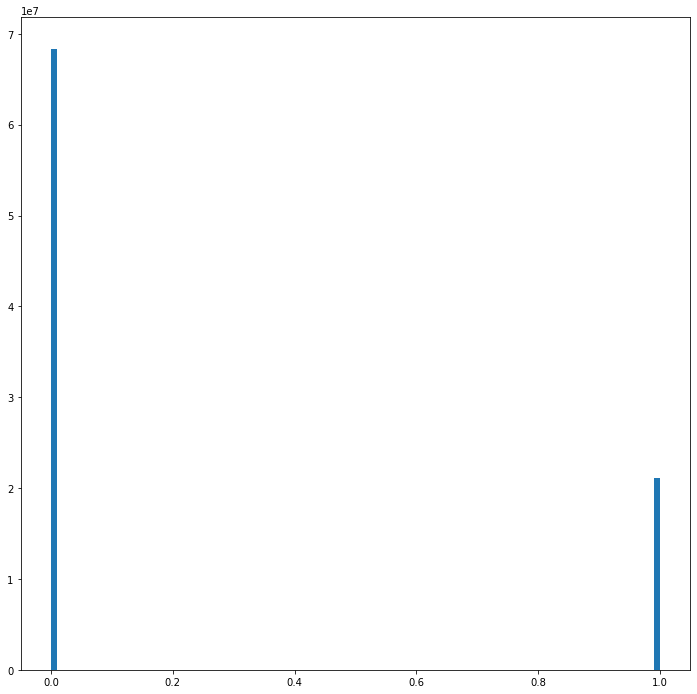

In [14]:
#Visualize the binarized fluorescence data in a histogram
plt.figure(figsize=(12, 12))

plt.hist(Fluo_binary_array, 100, linewidth=100)

plt.show()

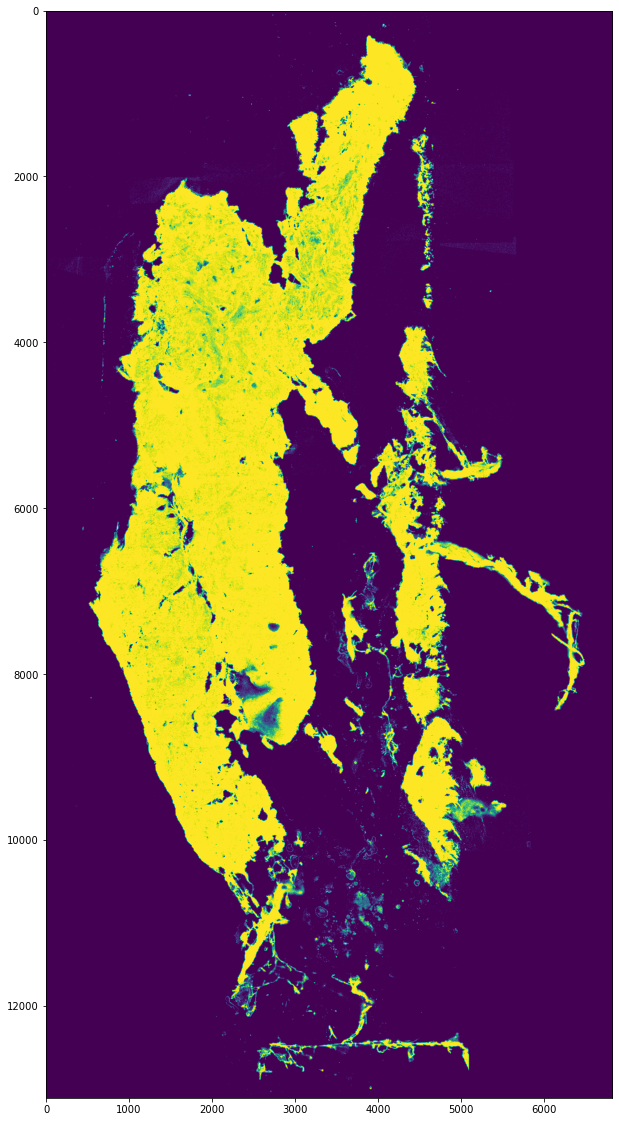

In [15]:
#Print a binarized version of the fluorescence image
Pict_print_viridis_selfAdj(Fluo_binary_array, 1, Fluo_x_dim, Fluo_y_dim)
plt.savefig(Save_Folder+'\\_Fluo_bin.tif')

In [16]:
#Create a matrix of binarized fluorescence data in the dimensions of the original fluorescence image
Fluo_binary_matrix = np.reshape(Fluo_binary_array, (Fluo_y_dim, Fluo_x_dim))

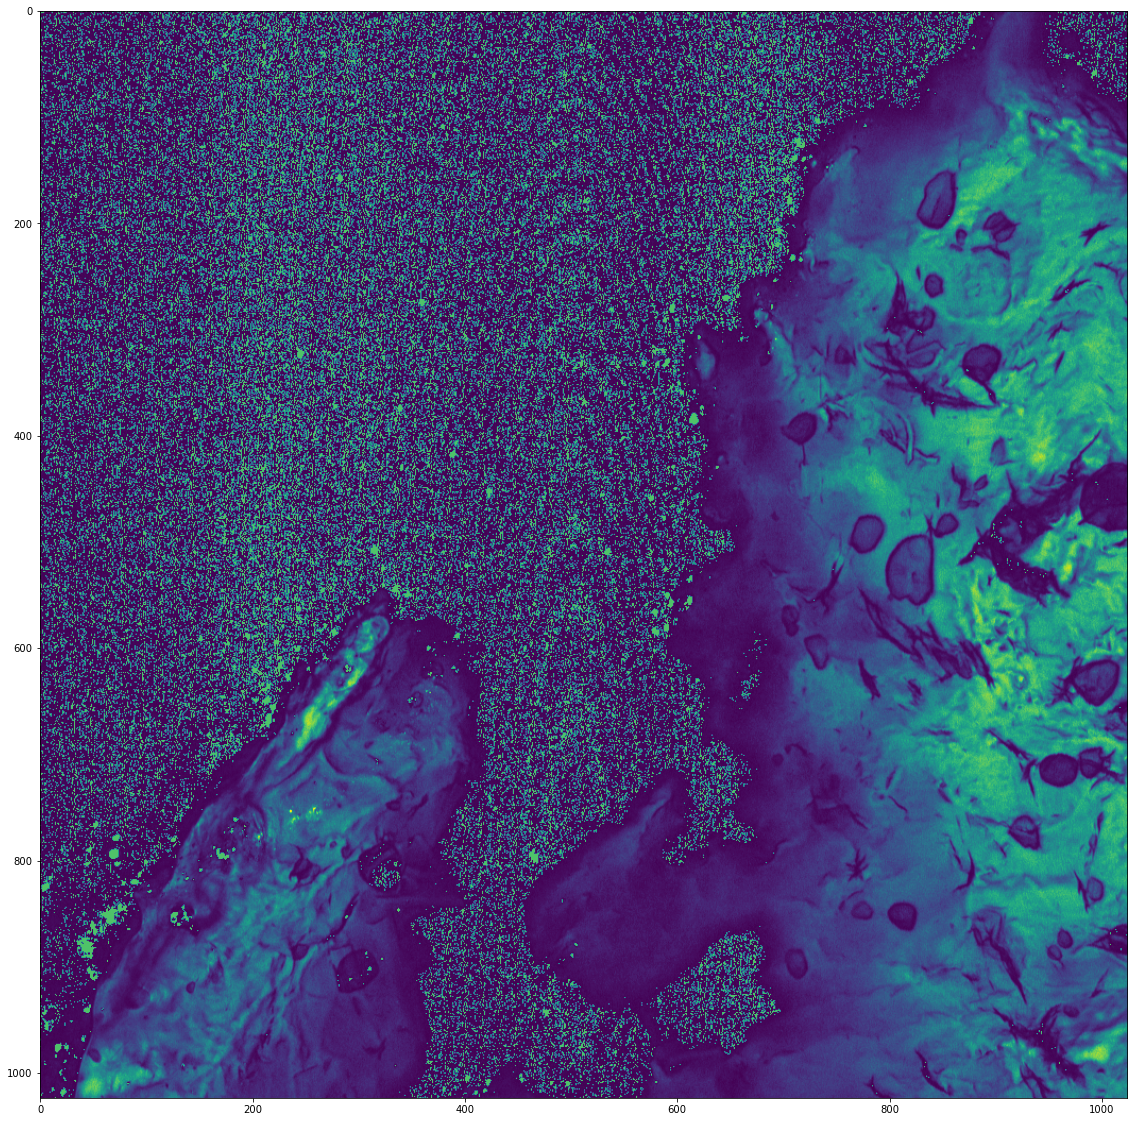

In [17]:
#Print the chosen exemplary Raman image that is used for the registration approach
Pict_print_viridis_selfAdj(Raman[Raman_image], 2, Raman_x_dim, Raman_y_dim)
plt.savefig(Save_Folder+'\\_Raman_used_for_reg.tif')

In [18]:
#Find maximum intensity of all Raman signals and find a threshold on a 5% niveau from that
Raman_max = Raman[Raman_image][np.argmax(Raman[Raman_image])]
Raman_Thresh = 0.05 * Raman_max

In [19]:
#Binarize the flattened array of Raman intensities based on the threshold
Raman_binary = Binarizer(Raman[Raman_image], Raman_Thresh)
Raman_binary_array = np.array(Raman_binary)

In [20]:
#Create a matrix of binarized Raman data in the dimensions of the original Raman image
Raman_binary_matrix = np.reshape(Raman_binary_array, (Raman_y_dim, Raman_x_dim))

In [21]:
# Use a first registration with determined step sizes for movement along the x-/ y-axis, limiting the number of computations.
# The output is an array of mismatches for each comparison, and for each comparison a positional value (x and y)
start = timer()
first_reg_mismatch, first_reg_positions = Auto_register(Fluo_binary_matrix, Raman_binary_matrix, Fluo_x_dim, Fluo_y_dim, stepsize_x=step_x, stepsize_y=step_y, Raman_x_dim=Raman_x_dim, Raman_y_dim=Raman_y_dim)
end = timer()
print(end - start)

Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwar

Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwar

Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwards
Moving downwar

In [22]:
#Determine minimal mismatch comparison for the first registration
first_reg_mismatch = np.array(first_reg_mismatch)
first_reg_min_mismatch = np.argmin(first_reg_mismatch)

#Acquire positional information (x-pos. and y-pos.) from the positional array
first_reg_positions = np.array(first_reg_positions)
first_reg_min_position = first_reg_positions[first_reg_min_mismatch]

In [23]:
#Perform a fine_grain single step registration in with 25 px steps in each direction around the best performing position
# of the coarse-grain registration
start = timer()
Optim_reg_mismatch, Optim_reg_positions = Position_optimizer(Fluo_binary_matrix, Raman_binary_matrix, Fluo_x_dim, Fluo_y_dim, first_reg_min_position, Raman_x_dim, Raman_y_dim)
end = timer()
print(end - start)

Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwards for optimization
Moving downwar

In [24]:
#Determine minimal mismatch comparison for the second registration
Optim_reg_mismatch = np.array(Optim_reg_mismatch)
Optim_reg_min_mismatch = np.argmin(Optim_reg_mismatch)

#Acquire positional information (x-pos. and y-pos.) from the positional array
Optim_reg_positions = np.array(Optim_reg_positions)
Optim_reg_min_position = Optim_reg_positions[Optim_reg_min_mismatch]

<Figure size 720x720 with 0 Axes>

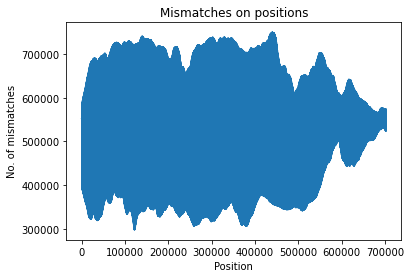

<Figure size 432x288 with 0 Axes>

In [35]:
#Generate two graphical representations:
# One showing all coarse-tested positions on the x-axis and the corresponding mismatches on the y-axis

positions_coarse = np.arange((first_reg_mismatch.shape[0]))
positions_fine = np.arange((Optim_reg_mismatch.shape[0]))

# Data for plotting

plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()


ax.plot(positions_coarse, first_reg_mismatch)

ax.set(xlabel='Position', ylabel='No. of mismatches',
       title='Mismatches on positions')


fig.savefig("Coarse_mismatch_plot.png")
plt.show()
plt.savefig(Save_Folder+'\\_Mismatch_plot_coarse.tif')

<Figure size 720x720 with 0 Axes>

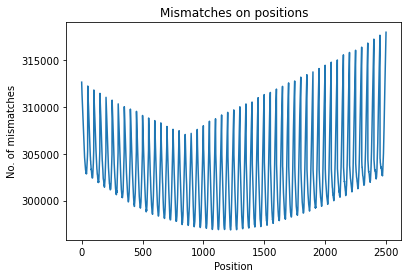

<Figure size 432x288 with 0 Axes>

In [26]:
#Generate two graphical representations:
# One showing all fine-tested positions on the x-axis and the corresponding mismatches on the y-axis

positions_fine = np.arange((Optim_reg_mismatch.shape[0]))

# Data for plotting

plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()


ax.plot(positions_fine, Optim_reg_mismatch)

ax.set(xlabel='Position', ylabel='No. of mismatches',
       title='Mismatches on positions')


fig.savefig("Fine_mismatch_plot.png")
plt.show()
plt.savefig(Save_Folder+'\\_Mismatch_plot_fine.tif')

In [27]:
aSYN_Fluo, aSYN_Fluo_raw = Raw_Plus_Loader(aSYN_Path_Fluo_data, aSYN_Ending_Fluo_data)

Reading image: Fluo_paSyn.tif


C:\Users\Philip\anaconda3\envs\ACT_Ker\lib\site-packages\PIL\Image.py:2858: DecompressionBombWarning: Image size (89488860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


(13110, 6826, 3)
(89488860, 1)


In [28]:
aSYN_Fluo_resh = np.reshape(aSYN_Fluo[0], (aSYN_Fluo_raw[0].shape[0], aSYN_Fluo_raw[0].shape[1]))
print(aSYN_Fluo_resh.shape)

(13110, 6826)


In [29]:
Optim_reg_min_position

array([ 698, 2099])

In [30]:
#Give out the best registered slice out of the fluorescence image

opti_slice = aSYN_Fluo_resh[(Optim_reg_min_position[1]):(Optim_reg_min_position[1]+Raman_y_dim), (Optim_reg_min_position[0]):(Optim_reg_min_position[0]+Raman_x_dim)]

In [31]:
opti_slice.shape

(1024, 1024)

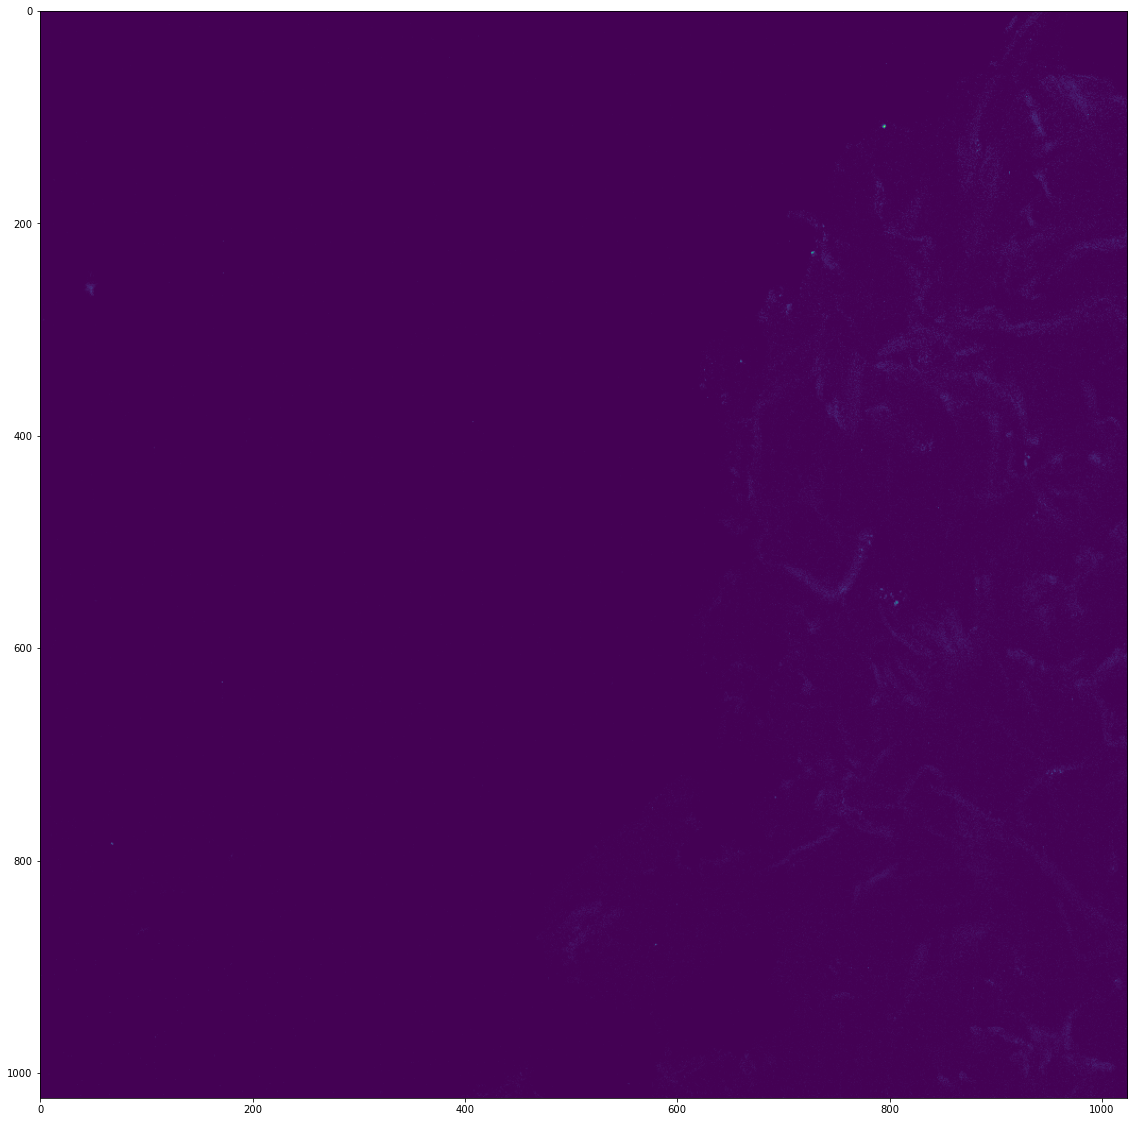

In [32]:
#Print the optimal fluorescence image slice
Pict_print_viridis_selfAdj(opti_slice, 5, Raman_x_dim, Raman_y_dim)
plt.savefig(Save_Folder+'\\_Raman_opti_slice.tif')

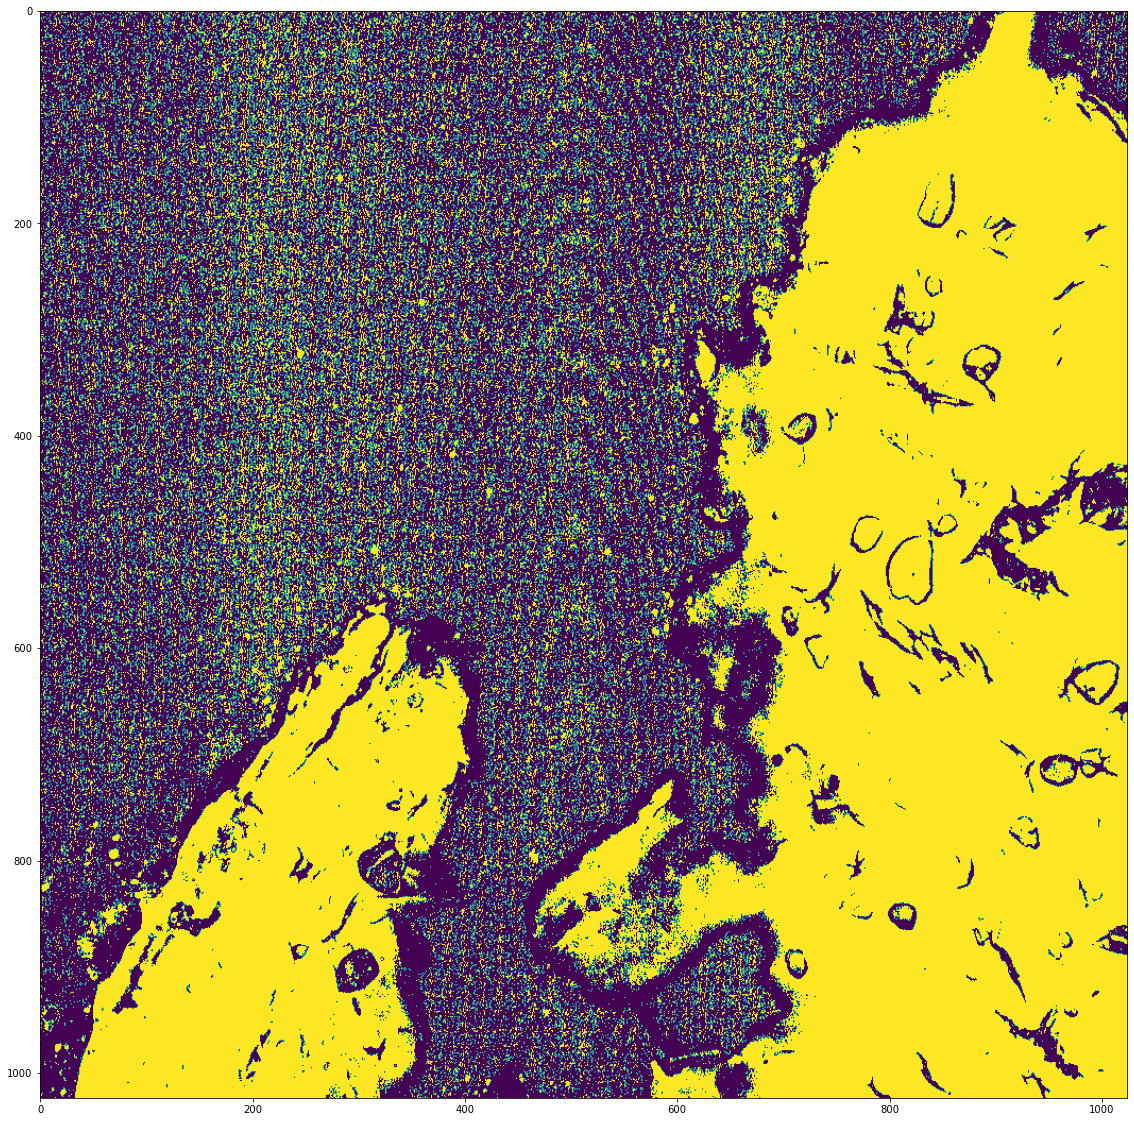

In [33]:
#Print the Raman image slice
Pict_print_viridis_selfAdj(Raman_binary_matrix, 6, Raman_x_dim, Raman_y_dim)
plt.savefig(Save_Folder+'\\_Raman_binary.tif')

In [34]:
np.save(Save_first_mismatch, first_reg_mismatch)
np.save(Save_first_positions, first_reg_positions)

np.save(Save_optim_mismatch, Optim_reg_mismatch)
np.save(Save_optim_positions, Optim_reg_positions)

np.save(Save_opti_slice, opti_slice)

np.save(Save_opti_slice_position, Optim_reg_min_position)